In [1]:
import sys
import os

# プロジェクトルートをsys.pathに追加
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH set to:", project_root)

PYTHONPATH set to: c:\Users\ndhaj\Desktop\TCI


Requested 400, effective 132 scan positions
[Noise] type=Gaussian, var=1e-05, SNR≈35.88 dB


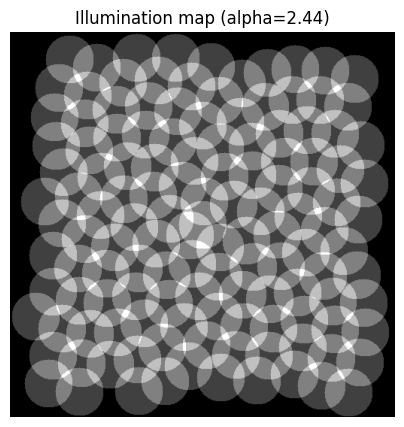

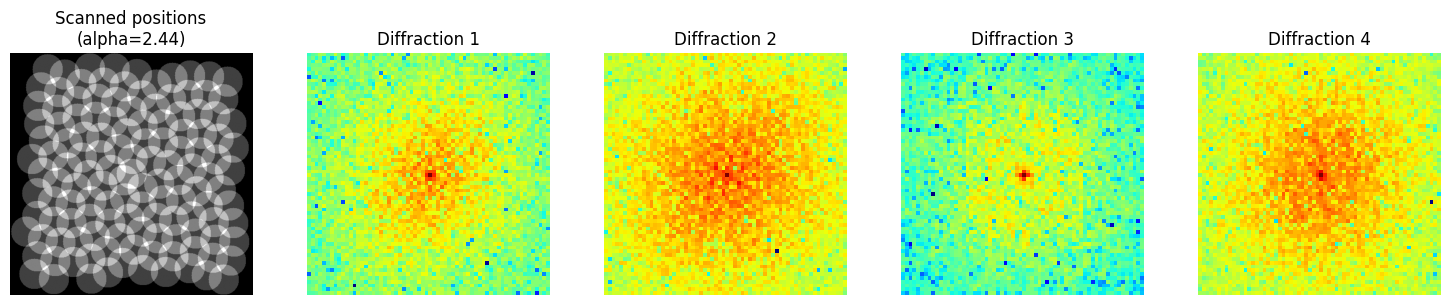

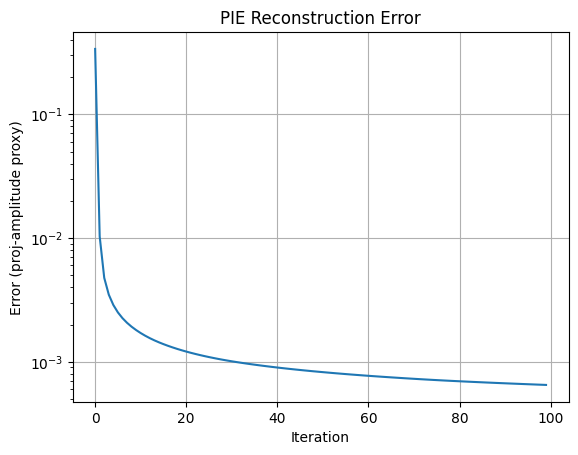

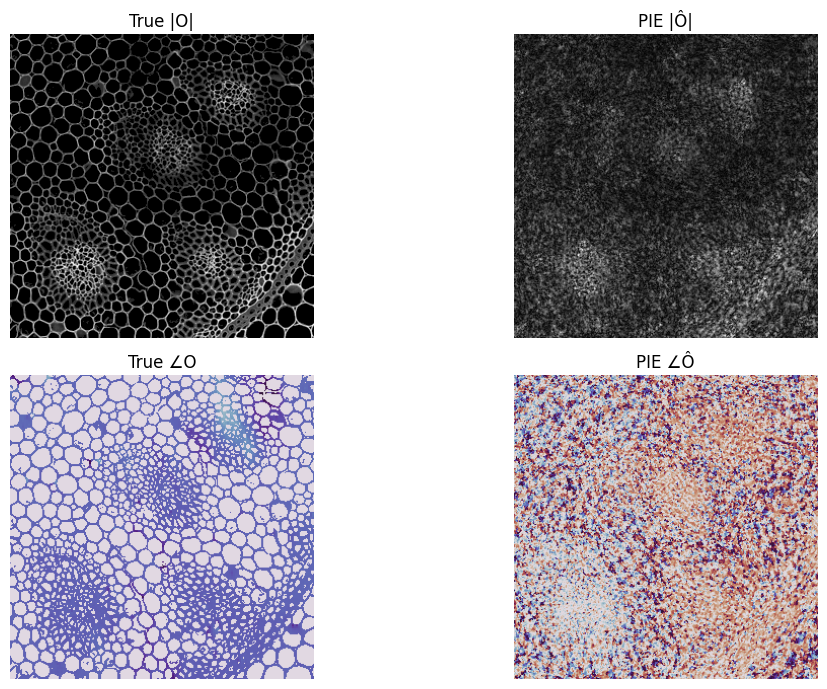

In [ ]:
# ===== Known-probe experiment template =====
# ノートブックの1セルで完結。復元像の可視化はフラグでON/OFFできます。

# --- 基本設定 ---
from dataclasses import dataclass
from typing import Optional

from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")

from PtychoEP.utils.ptycho.core import Ptycho  # Ptychoコンテナ
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.rng_utils import get_rng

from PtychoEP.utils.ptycho.aperture_utils import circular_aperture
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
from PtychoEP.utils.ptycho.visualize import compute_illumination, show_scan_and_diffs

from PtychoEP.utils.ptycho.noise import GaussianNoise  # Optional: PoissonNoise も可
from PtychoEP.utils.engines.pie import PIE

import matplotlib.pyplot as plt

@dataclass
class ExperimentConfig:
    image_size: int = 512                # オブジェクト画像の想定サイズ（lily/moonは内部で正方形に整形）
    probe_size: int = 64
    step: int = 22.8
    num_points_request: int = 400        # スキャン生成の希望点数（境界外は自動で除外されます）
    seed: int = 99
    add_noise: bool = True
    gaussian_var: float = 1e-5
    pie_alpha: float = 0.2
    n_iter: int = 100
    show_illumination: bool = True
    show_diffs: bool = True
    show_recon_images: bool = True      # ← optional 可視化

cfg = ExperimentConfig()

# --- 1) オブジェクト / プローブの生成 ---
ptycho = Ptycho()
rng = get_rng(seed=cfg.seed)

# 複素オブジェクト: lily(振幅) × exp(j*pi/2*moon(位相)) の合成
amp = load_data_image("lily.png")
phs = load_data_image("moon.png")
obj = amp * np().exp(1j * np().pi/2 * phs)

# 円形アパーチャの既知プローブ
probe = circular_aperture(size=cfg.probe_size, r=0.5)

ptycho.set_object(obj)
ptycho.set_probe(probe)

# --- 2) スキャン位置の生成 ---
positions = generate_spiral_scan_positions(
    image_size=cfg.image_size,
    probe_size=cfg.probe_size,
    step=cfg.step,
    num_points=cfg.num_points_request,
)
print(f"Requested {cfg.num_points_request}, effective {len(positions)} scan positions")

# --- 3) フォワード計算（回折振幅データの生成と登録） ---
ptycho.forward_and_set_diffraction(positions)  # 内部で forward を実行して登録
ptycho.sort_diffraction_data(key="center_distance")
# 参考: forward->登録の流れは Ptycho.forward_and_set_diffraction 内で generate_diffraction を呼ぶ実装です

# --- 4) （任意）ノイズ付与 ---
if cfg.add_noise:
    GaussianNoise(var=cfg.gaussian_var) @ ptycho
    if hasattr(ptycho, "noise_stats"):
        print(f"[Noise] type={ptycho.noise_stats['type']}, "
              f"var={cfg.gaussian_var}, SNR≈{ptycho.noise_stats['snr_mean_db']:.2f} dB")

# --- 5) 可視化（スキャン分布と回折パターン）※optional ---
if cfg.show_illumination:
    scan_img, alpha = compute_illumination(ptycho)
    plt.figure(figsize=(5,5))
    plt.imshow(scan_img, cmap="gray")
    plt.title(f"Illumination map (alpha={alpha:.2f})")
    plt.axis("off")
    plt.show()

if cfg.show_diffs:
    _ = show_scan_and_diffs(ptycho, num_patterns=4, log_scale=True)

# --- 6) PIE（ePIE相当：既知プローブ・オブジェクト更新）---
errors = []
def callback(iter_idx, err, obj_est):
    errors.append(err)

pie = PIE(ptycho, alpha=cfg.pie_alpha, callback=callback)
obj_pie = pie.run(n_iter=cfg.n_iter)

# --- 7) 誤差曲線の可視化 ---
plt.figure()
plt.plot(errors)
plt.xlabel("Iteration")
plt.ylabel("Error (proj-amplitude proxy)")
plt.yscale('log')
plt.title("PIE Reconstruction Error")
plt.grid(True)
plt.show()

# --- 8) （任意）復元像の振幅 / 位相 ---
if cfg.show_recon_images:
    sl = (slice(100, 400), slice(100, 400))  # 中心クロップ（見やすさのため）
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axes[0,0].imshow(np().abs(obj[sl]), cmap="gray");              axes[0,0].set_title("True |O|"); axes[0,0].axis("off")
    axes[1,0].imshow(np().angle(obj[sl]), cmap="twilight");        axes[1,0].set_title("True ∠O"); axes[1,0].axis("off")
    axes[0,1].imshow(np().abs(obj_pie[sl]), cmap="gray");          axes[0,1].set_title("PIE |Ô|"); axes[0,1].axis("off")
    axes[1,1].imshow(np().angle(obj_pie[sl]), cmap="twilight");    axes[1,1].set_title("PIE ∠Ô");  axes[1,1].axis("off")
    plt.tight_layout(); plt.show()


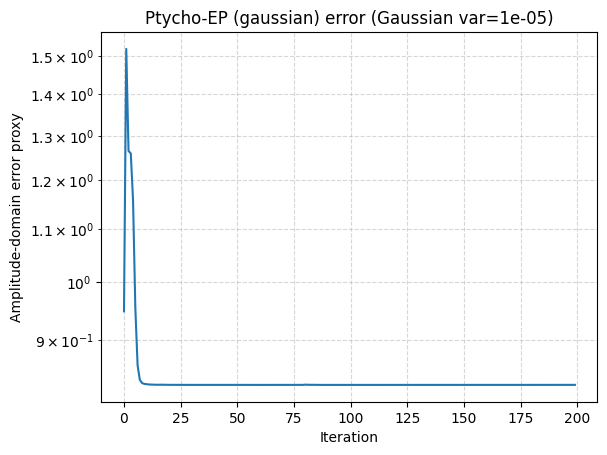

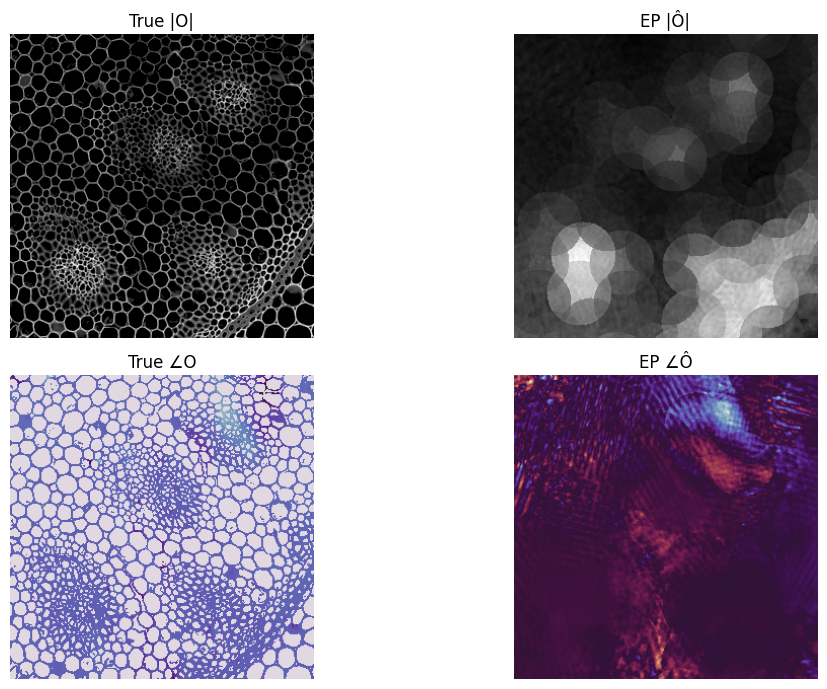

In [3]:
# =========================
# Ptycho-EP（Known Probe）実験ブロック
# =========================

# 事前に以下が実行済みである前提：
# ----------------------------------
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")
from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.rng_utils import normal, get_rng
from PtychoEP.utils.ptycho.aperture_utils import circular_aperture
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
ptycho = Ptycho()
obj = load_data_image("lily.png") * np().exp(1j * np().pi/2 * load_data_image("moon.png"))
probe = circular_aperture(size = 64, r = 0.5)
ptycho.set_object(obj); ptycho.set_probe(probe)
positions = generate_spiral_scan_positions(image_size=512, probe_size=64, step=22.8, num_points=400)
ptycho.forward_and_set_diffraction(positions)
ptycho.sort_diffraction_data(key="center_distance")

# --- （任意）ノイズ付加設定 ---
from PtychoEP.utils.ptycho.noise import GaussianNoise, PoissonNoise

use_noise = True            # Trueでノイズ付加
noise_type = "gaussian"      # "gaussian" or "poisson"
gauss_var  = 1e-5            # GaussianNoise の分散
poisson_I0 = 1e5             # PoissonNoise のスケール（平均光子数相当）

if use_noise:
    if noise_type == "gaussian":
        GaussianNoise(var=gauss_var) @ ptycho
    elif noise_type == "poisson":
        PoissonNoise(scale=poisson_I0) @ ptycho
    else:
        raise ValueError("noise_type must be 'gaussian' or 'poisson'.")

# --- Ptycho-EP 実行 ---
from PtychoEP.utils.engines.ptycho_ep.core import PtychoEP
import matplotlib.pyplot as plt

# prior_type: "gaussian"（既定） or "sparse"
prior_type   = "gaussian"     # "sparse" を試すときはここを変更
damping      = 0.9  # メッセージ更新の減衰（0<damping<=1）

ep_errors = []
def ep_callback(iter_idx, err, obj_est):
    ep_errors.append(err)

ep = PtychoEP(
    ptycho,
    prior_type=prior_type,
    damping=damping,
    prb_init=None,          # 既知プローブ前提：Noneならptycho.prbを使用
    callback=ep_callback
)

n_iter_ep = 200
obj_ep, prb_ep = ep.run(n_iter=n_iter_ep)

# --- 誤差推移の可視化 ---
plt.figure()
plt.plot(ep_errors)
plt.xlabel("Iteration")
plt.ylabel("Amplitude-domain error proxy")
plt.yscale("log")
ttl_noise = "no noise" if not use_noise else (f"Gaussian var={gauss_var}" if noise_type=="gaussian" else f"Poisson scale={poisson_I0:.0e}")
plt.title(f"Ptycho-EP ({prior_type}) error ({ttl_noise})")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- （任意）復元像のクイック可視化 ---
do_quick_view = True
if do_quick_view:
    y0, y1 = 100, 400
    x0, x1 = 100, 400
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axes[0,0].imshow(np().abs(obj[y0:y1, x0:x1]), cmap="gray");         axes[0,0].set_title("True |O|"); axes[0,0].axis("off")
    axes[1,0].imshow(np().angle(obj[y0:y1, x0:x1]), cmap="twilight");   axes[1,0].set_title("True ∠O");  axes[1,0].axis("off")
    axes[0,1].imshow(np().abs(obj_ep[y0:y1, x0:x1]), cmap="gray");      axes[0,1].set_title("EP |Ô|");   axes[0,1].axis("off")
    axes[1,1].imshow(np().angle(obj_ep[y0:y1, x0:x1]), cmap="twilight");axes[1,1].set_title("EP ∠Ô");    axes[1,1].axis("off")
    plt.tight_layout(); plt.show()

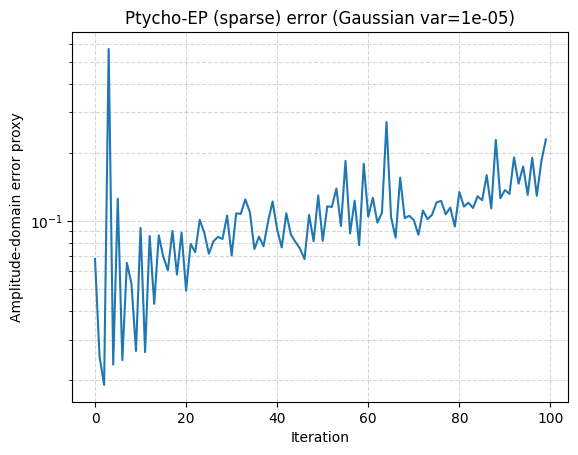

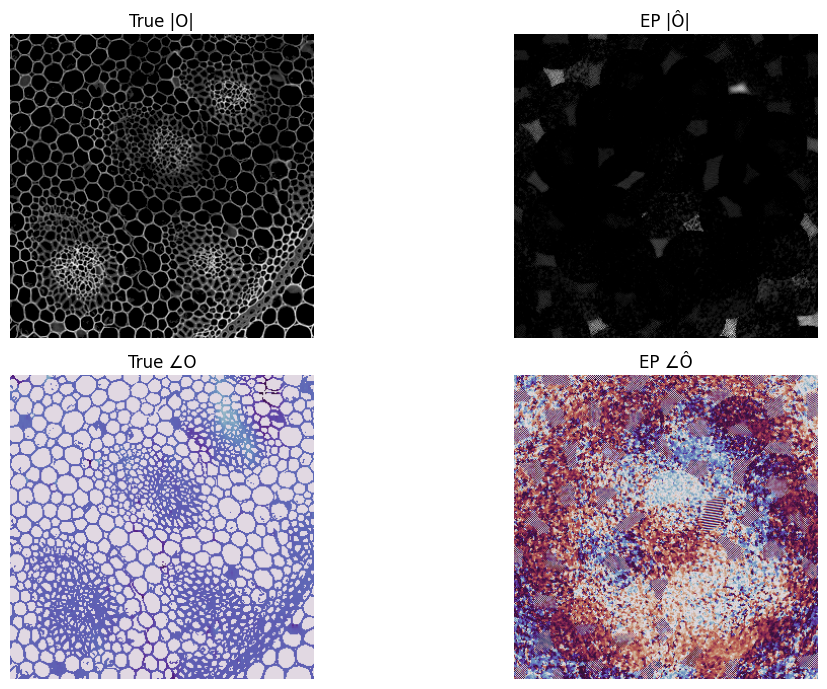

In [17]:
# =========================
# Ptycho-EP（Known Probe）実験ブロック
# =========================

# 事前に以下が実行済みである前提：
# ----------------------------------
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")
from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.rng_utils import normal, get_rng
from PtychoEP.utils.ptycho.aperture_utils import circular_aperture
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
ptycho = Ptycho()
obj = load_data_image("lily.png") * np().exp(1j * np().pi/2 * load_data_image("moon.png"))
probe = circular_aperture(size = 64, r = 0.5)
ptycho.set_object(obj); ptycho.set_probe(probe)
positions = generate_spiral_scan_positions(image_size=512, probe_size=64, step=22.8, num_points=400)
ptycho.forward_and_set_diffraction(positions)
ptycho.sort_diffraction_data(key="center_distance")

# --- （任意）ノイズ付加設定 ---
from PtychoEP.utils.ptycho.noise import GaussianNoise, PoissonNoise

use_noise = True            # Trueでノイズ付加
noise_type = "gaussian"      # "gaussian" or "poisson"
gauss_var  = 1e-5            # GaussianNoise の分散
poisson_I0 = 1e5             # PoissonNoise のスケール（平均光子数相当）

if use_noise:
    if noise_type == "gaussian":
        GaussianNoise(var=gauss_var) @ ptycho
    elif noise_type == "poisson":
        PoissonNoise(scale=poisson_I0) @ ptycho
    else:
        raise ValueError("noise_type must be 'gaussian' or 'poisson'.")

# --- Ptycho-EP 実行 ---
from PtychoEP.utils.engines.ptycho_ep.core import PtychoEP
import matplotlib.pyplot as plt

# prior_type: "gaussian"（既定） or "sparse"
prior_type   = "sparse"     # "sparse" を試すときはここを変更
prior_kwargs = {"rho": 0.5}   # prior_type="sparse" のときのみ有効
damping      = 0.9  # メッセージ更新の減衰（0<damping<=1）

ep_errors = []
def ep_callback(iter_idx, err, obj_est):
    ep_errors.append(err)

ep = PtychoEP(
    ptycho,
    prior_type=prior_type,
    prior_kwargs=(prior_kwargs if prior_type=="sparse" else None),
    damping=damping,
    prb_init=None,          # 既知プローブ前提：Noneならptycho.prbを使用
    callback=ep_callback
)

n_iter_ep = 100
obj_ep, prb_ep = ep.run(n_iter=n_iter_ep)

# --- 誤差推移の可視化 ---
plt.figure()
plt.plot(ep_errors)
plt.xlabel("Iteration")
plt.ylabel("Amplitude-domain error proxy")
plt.yscale("log")
ttl_noise = "no noise" if not use_noise else (f"Gaussian var={gauss_var}" if noise_type=="gaussian" else f"Poisson scale={poisson_I0:.0e}")
plt.title(f"Ptycho-EP ({prior_type}) error ({ttl_noise})")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- （任意）復元像のクイック可視化 ---
do_quick_view = True
if do_quick_view:
    y0, y1 = 100, 400
    x0, x1 = 100, 400
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axes[0,0].imshow(np().abs(obj[y0:y1, x0:x1]), cmap="gray");         axes[0,0].set_title("True |O|"); axes[0,0].axis("off")
    axes[1,0].imshow(np().angle(obj[y0:y1, x0:x1]), cmap="twilight");   axes[1,0].set_title("True ∠O");  axes[1,0].axis("off")
    axes[0,1].imshow(np().abs(obj_ep[y0:y1, x0:x1]), cmap="gray");      axes[0,1].set_title("EP |Ô|");   axes[0,1].axis("off")
    axes[1,1].imshow(np().angle(obj_ep[y0:y1, x0:x1]), cmap="twilight");axes[1,1].set_title("EP ∠Ô");    axes[1,1].axis("off")
    plt.tight_layout(); plt.show()

In [18]:
# ===== Metrics: global phase alignment + PMSE/NMSE/PSNR =====
from PtychoEP.utils.backend import np

def _vdot_masked(a, b, mask=None):
    if mask is None:
        return np().vdot(a, b)  # conj(a)@b
    a_m = a[mask]; b_m = b[mask]
    return np().vdot(a_m, b_m)

def phase_align(x_est, x_true, mask=None):
    """
    x_est の global phase を x_true に最小二乗で一致させる。
    mask が与えられれば、その領域上で位相を整合。
    """
    ip = _vdot_masked(x_true, x_est, mask=mask)  # conj(x_true) @ x_est
    theta = np().angle(ip)                       # 最小化解の偏角
    return x_est * np().exp(-1j * theta)

def mse(x_est, x_true, mask=None):
    if mask is None:
        diff2 = np().abs(x_est - x_true)**2
    else:
        diff2 = np().abs(x_est[mask] - x_true[mask])**2
    return float(np().mean(diff2))

def nmse(x_est, x_true, mask=None, eps=1e-12):
    if mask is None:
        denom = np().mean(np().abs(x_true)**2) + eps
    else:
        denom = np().mean(np().abs(x_true[mask])**2) + eps
    return mse(x_est, x_true, mask=mask) / float(denom)

def pmse(x_est, x_true, mask=None):
    """
    Phase-aligned MSE. global phase を整合してから MSE。
    """
    aligned = phase_align(x_est, x_true, mask=mask)
    return mse(aligned, x_true, mask=mask)

def pnmse(x_est, x_true, mask=None, eps=1e-12):
    """
    Phase-aligned NMSE. PMSE を真値パワーで正規化。
    """
    aligned = phase_align(x_est, x_true, mask=mask)
    return nmse(aligned, x_true, mask=mask, eps=eps)

def psnr_from_mse(mse_val, peak=1.0, eps=1e-12):
    # 物体の最大振幅をpeakに使うのが一般的。複素画像なので |·| を前提。
    return 10.0 * np().log10((peak**2) / (mse_val + eps))


In [19]:
from PtychoEP.utils.ptycho.visualize import compute_illumination

scan_img, alpha = compute_illumination(ptycho)
mask = scan_img > 0     # 照明が1回でも当たった画素のみ評価
print("mask coverage:", float(np().mean(mask))*100, "%")


mask coverage: 84.58328247070312 %


In [20]:
pie_errors_fit = []    # 既存: フィッティング誤差（投影側のproxy）
pie_errors_pmse = []   # 新規: 物体PMSE

def callback_pie(iter_idx, err_fit, obj_est):
    pie_errors_fit.append(err_fit)
    pie_errors_pmse.append(pmse(obj_est, obj, mask=mask))  # obj は真値

pie = PIE(ptycho, alpha=0.1, callback=callback_pie)
obj_pie = pie.run(n_iter=400)

In [21]:
ep_errors_fit = []
ep_errors_pmse = []

def callback_ep(iter_idx, err_fit, obj_est):
    ep_errors_fit.append(err_fit)
    ep_errors_pmse.append(pmse(obj_est, obj, mask=mask))

from PtychoEP.utils.engines.ptycho_ep.core import PtychoEP
ep = PtychoEP(ptycho, prior_type="gaussian", damping=0.8, callback=callback_ep)
obj_ep, _ = ep.run(n_iter=200)


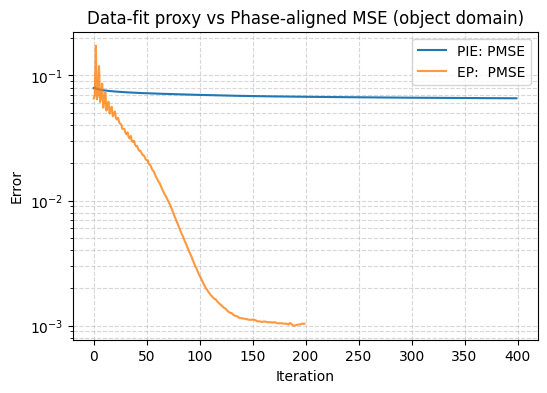

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
#plt.semilogy(pie_errors_fit,  label="PIE: fit-proxy")
#plt.semilogy(ep_errors_fit,   label="EP:  fit-proxy", alpha=0.8)
plt.semilogy(pie_errors_pmse, label="PIE: PMSE")
plt.semilogy(ep_errors_pmse,  label="EP:  PMSE", alpha=0.8)
plt.xlabel("Iteration"); plt.ylabel("Error"); plt.grid(True, which="both", ls="--", alpha=0.5)
plt.title("Data-fit proxy vs Phase-aligned MSE (object domain)")
plt.legend(); plt.show()